# QPD Diameter Trade-Off with Frequency Plan Input

In [108]:
import pandas as pd
import pprint
from functools import partial
import numpy
from matplotlib import pyplot
pyplot.style.use('dark_background')



## Load Frequency plan

In [109]:
with open("Data/example_f.dat", "r") as fp_file:
    fp_data = pd.read_csv(fp_file, sep=" ", header = None, skiprows=2)

print(fp_data)

           0       1      2    3      4      5       6       7       8
0     -5.300  -9.996 -6.543  5.0 -6.239 -7.280  14.486  22.490  20.986
1     -5.322 -10.001 -6.542  5.0 -6.237 -7.345  14.422  22.484  20.955
2     -5.345 -10.009 -6.541  5.0 -6.236 -7.415  14.354  22.475  20.923
3     -5.371 -10.020 -6.539  5.0 -6.235 -7.488  14.282  22.463  20.889
4     -5.398 -10.033 -6.538  5.0 -6.233 -7.567  14.205  22.448  20.853
...      ...     ...    ...  ...    ...    ...     ...     ...     ...
3923 -16.827 -18.463 -5.194  5.0 -5.275 -6.567  22.103  21.599   5.505
3924 -16.865 -18.284 -5.179  5.0 -5.286 -6.659  21.999  21.790   5.481
3925 -16.896 -18.102 -5.165  5.0 -5.297 -6.754  21.893  21.983   5.465
3926 -16.919 -17.918 -5.153  5.0 -5.305 -6.852  21.786  22.175   5.453
3927 -16.927 -17.817 -5.149  5.0 -5.309 -6.908  21.728  22.280   5.449

[3928 rows x 9 columns]


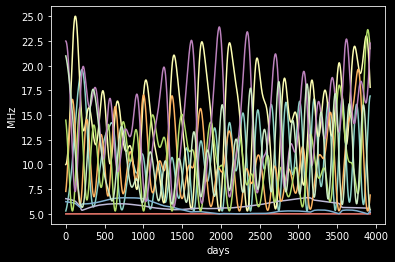

In [110]:
fp_plot = pyplot.plot(abs(fp_data))
pyplot.xlabel("days")
pyplot.ylabel("MHz")
pyplot.show(fp_plot)

## Generate QPR Noise Model

The input noise model has been previously established via EXCEL based analysis and manually tuned to the latest NIKEHF measurements.

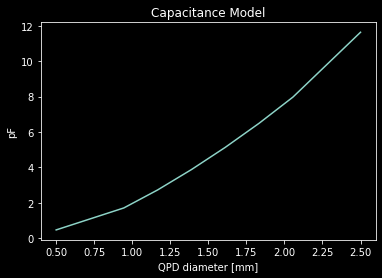

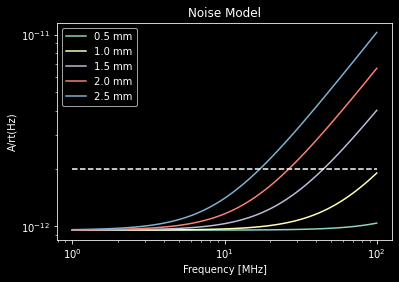

In [111]:
R_FB = 42200 #Ohms
T = 294 #K
k = 1.38e-23 #J/K
I_OP = 0.725 #pA/rt(Hz)
U_OP = 1.4 #nV/rt(Hz)

capacitance = lambda d: numpy.interp(d, [0.5, 1.0, 1.5, 2.0, 2.5], [0.465, 1.861, 4.450, 7.510, 11.634])
input_noise = lambda f,c: numpy.sqrt(4*k*T/R_FB+(I_OP*1e-12)**2+(U_OP*1e-9*2*numpy.pi*f*1e6*c*1e-12)**2)

c_range = numpy.linspace(0.5,2.5,10)
c_plot = pyplot.plot(c_range, capacitance(c_range))
pyplot.title("Capacitance Model")
pyplot.xlabel("QPD diameter [mm]")
pyplot.ylabel("pF")

f_range = [1*10**x for x in numpy.linspace(0,2,100)]

f_plot = pyplot.figure()

for d in [0.5,1.0,1.5,2.0,2.5]:
    pyplot.plot(f_range, [input_noise(f,capacitance(d)) for f in f_range], label=f"{d} mm")
pyplot.loglog()
pyplot.title("Noise Model")
pyplot.xlabel("Frequency [MHz]")
pyplot.ylabel("A/rt(Hz)")
pyplot.legend()
pyplot.plot([f_range[0],f_range[-1]],[2e-12,2e-12], linestyle = "dashed", color="white")



## Combine Noise model with frequency plan

We take the max of the daily rms of the six largest noise contributors

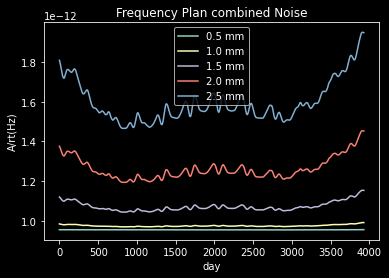

In [112]:
combined_noise = pyplot.figure()

max_noise_6 = {}
max_noise_9 = {}

for d in [0.5,1.0,1.5,2.0,2.5]:

    noise_map_func = lambda f: input_noise(f, capacitance(d))

    noise_map = fp_data.applymap(noise_map_func)

    #make the rms removing the 2 smallest values first
    rms_6 = noise_map.apply(lambda noise: (numpy.mean([x**2 for x in noise.sort_values()[3:]]))**0.5, axis=1)
    rms_9 = noise_map.apply(lambda noise: (numpy.mean([x**2 for x in noise.sort_values()[:]]))**0.5, axis=1)

    max_noise_6[d]=max(rms_6)

    max_noise_9[d]=max(rms_9)

    pyplot.plot(rms_6, label=f"{d} mm")

pyplot.title("Frequency Plan combined Noise")
pyplot.xlabel("day")
pyplot.ylabel("A/rt(Hz)")
pyplot.legend()
#pyplot.plot(pyplot.gca().get_xlim(),[2e-12,2e-12], linestyle = "dashed", color="white")
pyplot.show(combined_noise)


In [113]:
pprint.pprint(max_noise_6)

{0.5: 9.564575184371718e-13,
 1.0: 9.92043046278754e-13,
 1.5: 1.1545803988701068e-12,
 2.0: 1.4541527753156421e-12,
 2.5: 1.9494752864924157e-12}


## Sensitivity of the Top Level Performance

Extracted from sensitivity analysis of the CCPM for Input Noise and TTL

In [114]:
ccpm_inp_noise= [5.000000E-13,	
                 8.333334E-13,	
                 1.166660E-12,	
                 1.500000E-12,	
                 1.833340E-12,	
                 2.166660E-12,	
                 2.500000E-12,	
                 2.833334E-12,	
                 3.166666E-12,	
                 3.500000E-12]	

ccpm_tdi_x = [3.1896160E-11,
              3.2424520E-11,
              3.3201240E-11,
              3.4209510E-11,
              3.5429530E-11,
              3.6839900E-11,
              3.8420600E-11,
              4.0151030E-11,
              4.2011550E-11,
              4.3987730E-11]

estimate_perf= lambda inp_noise, ttl: numpy.interp(inp_noise, ccpm_inp_noise, ccpm_tdi_x) 

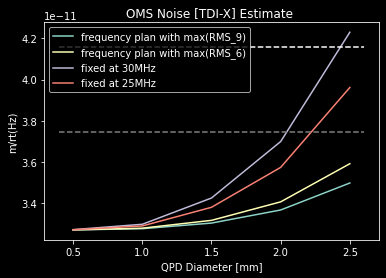

In [123]:
performance_plot = pyplot.figure()
pyplot.plot(max_noise_9.keys(), [estimate_perf(noise,0) for noise in max_noise_9.values()], label="frequency plan with max(RMS_9)")
pyplot.plot(max_noise_6.keys(), [estimate_perf(noise,0) for noise in max_noise_6.values()], label="frequency plan with max(RMS_6)")
pyplot.plot(max_noise_6.keys(), [estimate_perf(input_noise(30,capacitance(d)),0) for d in max_noise_6.keys()], label="fixed at 30MHz")
pyplot.plot(max_noise_6.keys(), [estimate_perf(input_noise(25,capacitance(d)),0) for d in max_noise_6.keys()], label="fixed at 25MHz")
limits=pyplot.gca().get_xlim()
pyplot.plot(limits,[4.16e-11,4.16e-11], linestyle = "dashed", color="white")
pyplot.plot(limits,[0.9*4.16e-11,0.9*4.16e-11], linestyle = "dashed", color="grey")
pyplot.title("OMS Noise [TDI-X] Estimate ")
pyplot.xlabel("QPD Diameter [mm]")
pyplot.ylabel("m/rt(Hz)")
pyplot.legend()
pyplot.show(performance_plot)